# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

**Признаки**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

### Установка библиотек и настройка окружения

In [1]:
# Базовые библиотеки для работы с данными
import pandas as pd
import numpy as np

# Визуализация
import seaborn as sns
import matplotlib.pyplot as plt

# Модели и инструменты машинного обучения
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, mean_squared_error, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Модели градиентного бустинга
from catboost import CatBoostRegressor, CatBoostClassifier
import lightgbm as lgb

# Статистика и оптимизация
import scipy.stats as stats
from scipy.stats import randint as sp_randint, uniform, poisson
from scipy.stats import randint
# Анализ и интерпретация моделей
import shap

# Утилиты
from IPython.display import display
import warnings
import time

# Библиотеки для анализа данных
import phik
from phik import report

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

c:\Users\42\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pd.set_option('display.min_rows', 15)
pd.set_option('display.max_rows', 20)
pd.options.display.float_format = '{:,.2f}'.format

### Инициализация полезных функций

In [3]:
# вначале работал с урезанным датасетом, чтобы быстрее все прогружалось
def get_stratified_sample(data, stratify_column='column_for_stratification', sample_size=100000):
    # Разделение данных на обучающий набор (который будет отброшен) и "тестовый" набор, который является нужной выборкой
    _, data_sample = train_test_split(data, test_size=sample_size, stratify=data[stratify_column], random_state=42)
    
    return data_sample

In [4]:
class DatasetSizeTracker:
    def __init__(self):
        self.initial_size = None
        self.previous_size = None

    def track(self, data):
        # Если исходный размер не был установлен, запоминаем его и текущий размер как первоначальный
        if self.initial_size is None:
            self.initial_size = len(data)
            self.previous_size = len(data)
            loss_from_initial = 0
            loss_from_previous = 0
            loss_percent_overoll = 0
        else:
            # Считаем, сколько строк потеряно относительно исходного размера и с прошлого вызова
            current_size = len(data)
            loss_from_initial = self.initial_size - current_size
            loss_from_previous = self.previous_size - current_size
            loss_percent_overoll = ((self.initial_size - current_size)/self.initial_size)*100
            # обновляем преддущий размер для следующего вызова
            self.previous_size = current_size
        
        return {"Потери от исходного размера": loss_from_initial, "Потери с предыдущего раза": loss_from_previous,
                'Общие потери в процентах' : loss_percent_overoll}

# Создание экземпляра класса для трекинга 
tracker = DatasetSizeTracker()

In [5]:
# функция информации по таблице
def dataframe_summary(df, string):
    # Вывод общей информации
    print("Общая информация по таблице:", string)
    df.info()

    print("\n Статистическое описание:")
    display(df.describe().transpose())

    print("\nСлучайные примеры:")
    display(df.sample(5))

    print("\nКоличество строк и столбцов:", df.shape)

    print("\nКоличество явных дубликатов:", df.duplicated().sum())
    print('')

In [6]:
# функция поиска пропусков
def analyze_missing_values(df, string):
        total = df.isnull().sum().sort_values(ascending=False)
        percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        missing_data = missing_data.query('Total > 0')

        # Вывод информации о пропусках
        print(f"Пропуски в датафрейме {string}:\n{missing_data}\n")

        # Создание и отображение тепловой карты
        plt.figure(figsize=(12, 8))
        sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
        plt.title(f"Heatmap пропусков для {string}")
        plt.show()

In [7]:
# Функция для преобразования названий в змеиный регистр (snake_case) 
def to_snake_case(name): 
    s1 = name[0].lower() 
    for c in name[1:]: 
        if c.isupper(): 
            s1 += '_' 
            s1 += c.lower() 
        else: 
            s1 += c 
    return s1 
 

In [8]:
def fill_missing_values_by_brand_and_model(data, column_name):
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if pd.isnull(row[column_name]):
            return most_frequent_values.get((row['brand'], row['model']), row[column_name])
        else:
            return row[column_name]

    data[column_name] = data.apply(fill_value, axis=1)
    
    return data

### Обзор данных, работа с дубликатами, пропусками и выбросами

План работы:
1) Анализ описательной статитстики по данным;
2) Очистка явных дубликатов;
3) Обработка пропусков;
4) Обработка выбросов;
5) Анализ визуальной статистики.

#### Обзор данных

In [9]:
data = pd.read_csv('autos.csv')

In [10]:
# Для использования функции, укажите DataFrame, колонку для стратификации и желаемый размер выборки:
# data = get_stratified_sample(data, 'Brand', 150000)

In [11]:
dataframe_summary(data, 'Автомобили (data)')

Общая информация по таблице: Автомобили (data)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           35

,count,mean,std,min,25%,50%,75%,max
Price,"354,369.00","4,416.66","4,514.16",0.00,"1,050.00","2,700.00","6,400.00","20,000.00"
RegistrationYear,"354,369.00","2,004.23",90.23,"1,000.00","1,999.00","2,003.00","2,008.00","9,999.00"
Power,"354,369.00",110.09,189.85,0.00,69.00,105.00,143.00,"20,000.00"
Kilometer,"354,369.00","128,211.17","37,905.34","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"
RegistrationMonth,"354,369.00",5.71,3.73,0.00,3.00,6.00,9.00,12.00
NumberOfPictures,"354,369.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00
PostalCode,"354,369.00","50,508.69","25,783.10","1,067.00","30,165.00","49,413.00","71,083.00","99,998.00"



Случайные примеры:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
293023,2016-04-02 12:58:54,250,sedan,1996,manual,116,3er,150000,11,petrol,bmw,NaN,2016-04-02 00:00:00,0,64319,2016-04-02 12:58:54
353633,2016-03-23 23:55:21,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,NaN,2016-03-23 00:00:00,0,45277,2016-03-27 01:15:17
220226,2016-03-25 18:46:48,2990,bus,2002,manual,116,sharan,150000,4,petrol,volkswagen,no,2016-03-25 00:00:00,0,54453,2016-04-07 00:17:30
66668,2016-03-22 19:50:52,1760,wagon,1999,manual,101,passat,150000,4,petrol,volkswagen,no,2016-03-22 00:00:00,0,48161,2016-03-25 12:17:51
209840,2016-03-26 18:40:10,5555,bus,2004,manual,116,sharan,150000,5,gasoline,volkswagen,no,2016-03-26 00:00:00,0,31515,2016-04-02 10:15:23



Количество строк и столбцов: (354369, 16)

Количество явных дубликатов: 4



In [12]:
tracker = DatasetSizeTracker()

tracker.track(data)  # Посмотреть, сколько строк потеряно с исходного момента и с последнего вызова

{'Потери от исходного размера': 0,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 0}

Изменим названия переменных, избавимся от дубликатов

In [13]:
data.columns = [to_snake_case(name) for name in data.columns] 
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [14]:
# удалим явные дубликаты
data.drop_duplicates(inplace=True)

В данных есть объявления с ценой равной 0. Тк это целевой признак - менять нельзя, но лучше удалить строки с такой ценой.

In [15]:
print('Сколько людей готовы "подарить" автомобиль:',len(data.loc[data['price'] == 0]))
data = data.loc[data['price'] != 0]
print('Сколько людей готовы "подарить" автомобиль теперь:',len(data.loc[data['price'] == 0]))

Сколько людей готовы "подарить" автомобиль: 10772
Сколько людей готовы "подарить" автомобиль теперь: 0


In [16]:
tracker.track(data) 

{'Потери от исходного размера': 10776,
 'Потери с предыдущего раза': 10776,
 'Общие потери в процентах': 3.0408980469510594}

Пропуски в датафрейме data:
              Total  Percent
repaired      65866    19.17
vehicle_type  33750     9.82
fuel_type     29459     8.57
model         17521     5.10
gearbox       17355     5.05



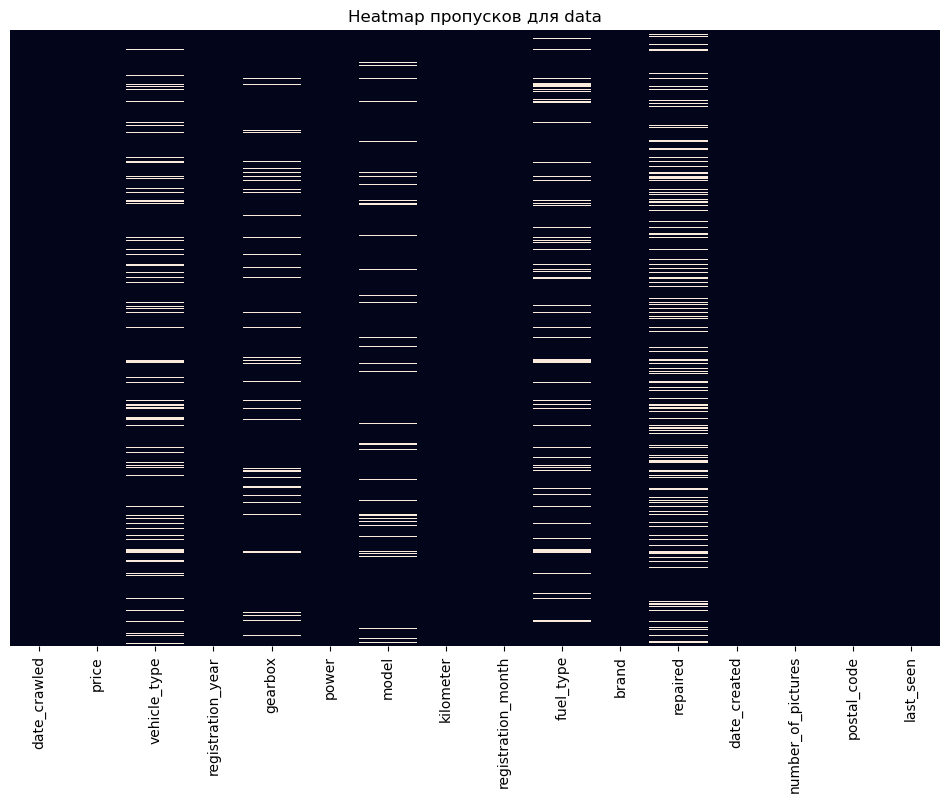

In [17]:
analyze_missing_values(data, 'data')

Избавимся от явных дубликатов, возможно, после обработки датасета и удаления ненужных переменных дубликатов станет больше.

In [18]:
data = data.drop(['date_crawled', 'registration_month', 'date_created', 
                  'number_of_pictures', 'postal_code', 'last_seen'], axis =1) 

In [19]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

In [20]:
display(data[['brand', 'model','vehicle_type', 'fuel_type', 'gearbox', 'power' ,'repaired','price']].sample(10))

,brand,model,vehicle_type,fuel_type,gearbox,power,repaired,price
335483,volkswagen,golf,small,petrol,manual,59,no,300
178914,renault,twingo,small,petrol,manual,58,no,850
348461,mercedes_benz,c_klasse,sedan,gasoline,manual,136,no,10500
215959,bmw,3er,wagon,petrol,auto,150,no,1450
188565,audi,a3,sedan,petrol,manual,101,no,2199
262653,audi,a4,wagon,petrol,auto,0,no,4850
295082,mercedes_benz,e_klasse,wagon,NaN,manual,177,yes,4500
14872,bmw,3er,sedan,NaN,NaN,101,NaN,1180
320789,seat,exeo,sedan,gasoline,manual,143,no,8000
189868,renault,megane,sedan,petrol,manual,113,NaN,2499


#### Работа с пропусками

##### Пропуски в `model`

Пропуски в `model`, на мой взгляд, критичны. Фактор модели может играть значительную роль в определении цены машины. Восполнить пропуски здесь никак, заглушка тоже может в данном случае не подойти или нарушить связи. 

In [21]:
data = data.loc[~data['model'].isna()]
tracker.track(data) 

{'Потери от исходного размера': 28297,
 'Потери с предыдущего раза': 17521,
 'Общие потери в процентах': 7.985179290513561}

##### Пропуски в `repaired`

Пропусков в repaired довольно много, порядка 20% от изначального размера данных.\
Фактор довольно важный, при написании объявления обязательно указывать, если машина ремонтировалась. Возможно, значения в этом столбце пропущены, если машина не чинилась и продавцы оставляли незаполненным этот пропуск. \
Если качество модели будет неудовлетворительным, можно попробовать применить заглушку.


In [22]:
data.repaired.value_counts()

repaired
no     235821
yes     31958
Name: count, dtype: int64

In [23]:
data.repaired.fillna('no', inplace=True)

Пропуски в датафрейме data:
              Total  Percent
vehicle_type  28166     8.64
fuel_type     23551     7.22
gearbox       14270     4.38



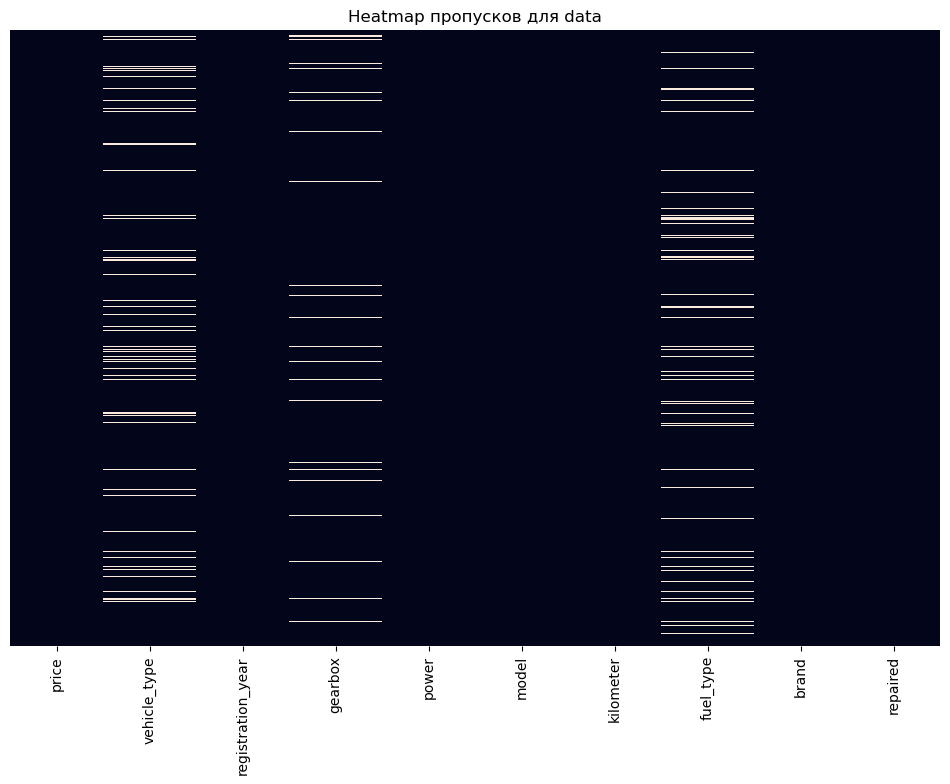

In [24]:
analyze_missing_values(data, 'data')

Остались пропуски в `vehicle_type`,  `fuel_type` и `gearbox` - их заполним на основе данных из `model` и `brand`. 

In [25]:
print(data['vehicle_type'].value_counts())
print(data['fuel_type'].value_counts())
print(data['gearbox'].value_counts())

vehicle_type
sedan          86339
small          74907
wagon          61703
bus            27427
convertible    19038
coupe          14774
suv            11067
other           2651
Name: count, dtype: int64
fuel_type
petrol      202251
gasoline     94503
lpg           4845
cng            534
hybrid         204
other          119
electric        65
Name: count, dtype: int64
gearbox
manual    249988
auto       61814
Name: count, dtype: int64


In [26]:
# используем функцию для заполнения пропусков на основе сгрупиированных данных по brand и model
missing_list = ['vehicle_type', 'fuel_type', 'gearbox']
for i in missing_list:
    data = fill_missing_values_by_brand_and_model(data, i)


In [27]:
print(data['vehicle_type'].value_counts())
print(data['fuel_type'].value_counts())
print(data['gearbox'].value_counts())

vehicle_type
sedan          97918
small          83363
wagon          64900
bus            30942
convertible    19283
coupe          15323
suv            11669
other           2674
Name: count, dtype: int64
fuel_type
petrol      221317
gasoline     98988
lpg           4845
cng            534
hybrid         204
other          119
electric        65
Name: count, dtype: int64
gearbox
manual    262435
auto       63637
Name: count, dtype: int64


#### Обработка аномальных значений

In [28]:
data.describe()

,price,registration_year,power,kilometer
count,"326,072.00","326,072.00","326,072.00","326,072.00"
mean,"4,623.01","2,003.95",111.98,"128,565.73"
std,"4,530.62",66.76,182.97,"37,010.32"
min,1.00,"1,000.00",0.00,"5,000.00"
25%,"1,200.00","1,999.00",71.00,"125,000.00"
50%,"2,950.00","2,003.00",105.00,"150,000.00"
75%,"6,649.00","2,008.00",143.00,"150,000.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00"


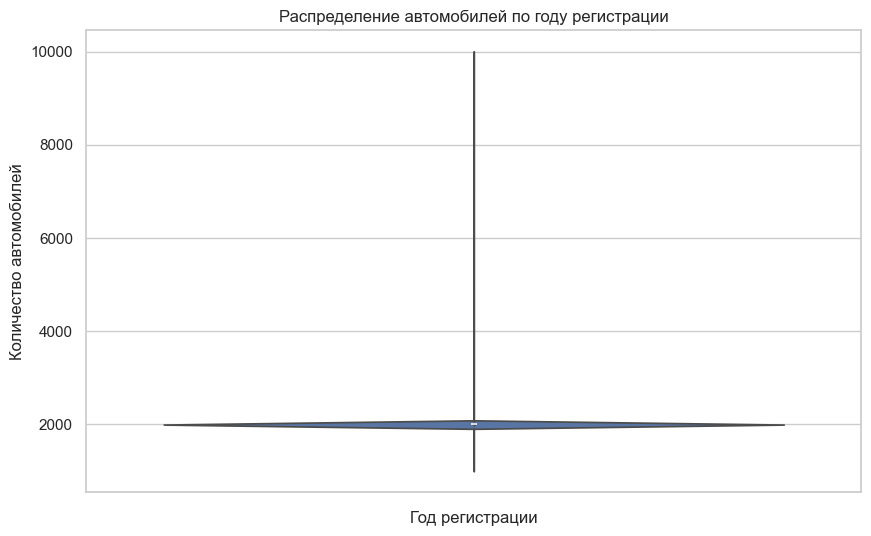

In [29]:
sns.set(style="whitegrid")

# Создание графика распределения значений по годам
plt.figure(figsize=(10, 6))
sns.violinplot(data['registration_year'])

plt.title('Распределение автомобилей по году регистрации') 
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45) 

plt.show() 

В данном столбце много выбросов, обработаем выбивающиеся значения. \
Границы отбора данных на изменение предлагаю определить такие:
 * Верхний потолок - 2024 год (машины из 2025года+ пока не производят, к сожалению не придумали)
 * Нижний потолок - машины старше 1980 года. Машин с более поздним годом выпуска совсем немного. 

In [30]:
print(f"Строки с годом регистрации до 1980 или после 2024 составляют {(len(data[(data['registration_year'] < 1980) |  (data['registration_year'] > 2024)]) / len(data)) * 100:.2f}% от всего датасета.")

Строки с годом регистрации до 1980 или после 2024 составляют 0.76% от всего датасета.


In [31]:
tracker.track(data) 

{'Потери от исходного размера': 28297,
 'Потери с предыдущего раза': 0,
 'Общие потери в процентах': 7.985179290513561}

In [32]:
data = data[(data['registration_year'] >= 1985) & (data['registration_year'] <= 2024)]

In [33]:
tracker.track(data) 

{'Потери от исходного размера': 32323,
 'Потери с предыдущего раза': 4026,
 'Общие потери в процентах': 9.121283182219663}

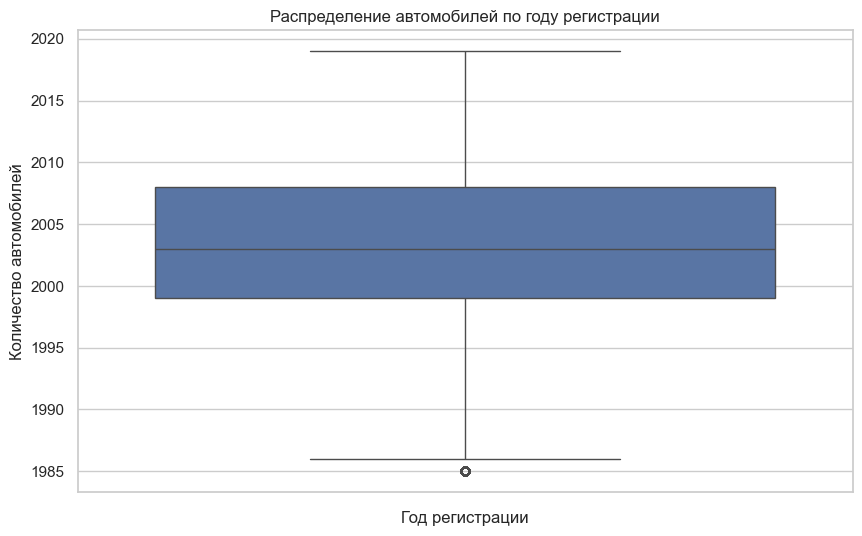

In [34]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['registration_year'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

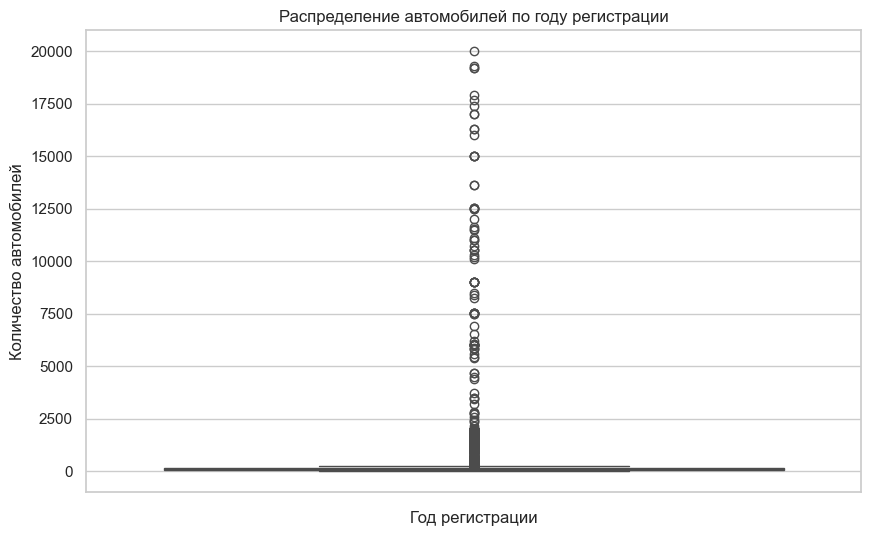

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['power'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

In [36]:
print(f"Строки с слишком большой или малой мощностью составляют {(len(data[(data['power'] < 45) |   (data['power'] > 450)]) / len(data)) * 100:.2f}% от всего датасета.")

Строки с слишком большой или малой мощностью составляют 10.11% от всего датасета.


In [37]:
data_grp = data.groupby(['brand', 'model', 'vehicle_type'])['power'].apply(lambda x: x.median())

In [38]:
def replace_outliers(data, column_name):
    # Считаем самое частое значение для каждой группы 'brand' и 'model'
    most_frequent_values = data.groupby(['brand', 'model', 'vehicle_type'])[column_name].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    
    # Функция для заполнения пропуска
    def fill_value(row):
        if row['power'] < 45 or row['power'] > 450:
            return most_frequent_values.get((row['brand'], row['model'], row['vehicle_type']), row[column_name])
        else:
            return row[column_name]
    
    # Заполнение пропусков
    data[column_name] = data.apply(fill_value, axis=1)

    return data

In [39]:
replace_outliers(data, 'power')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,75,golf,150000,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,no
...,...,...,...,...,...,...,...,...,...,...
354360,3999,wagon,2005,manual,150,3er,150000,gasoline,bmw,no
354361,5250,wagon,2016,auto,150,159,150000,gasoline,alfa_romeo,no


In [40]:
data = data[(data['power'] <= 450) & (data['power'] >= 45)]

tracker.track(data) 

{'Потери от исходного размера': 35164,
 'Потери с предыдущего раза': 2841,
 'Общие потери в процентах': 9.922989877782763}

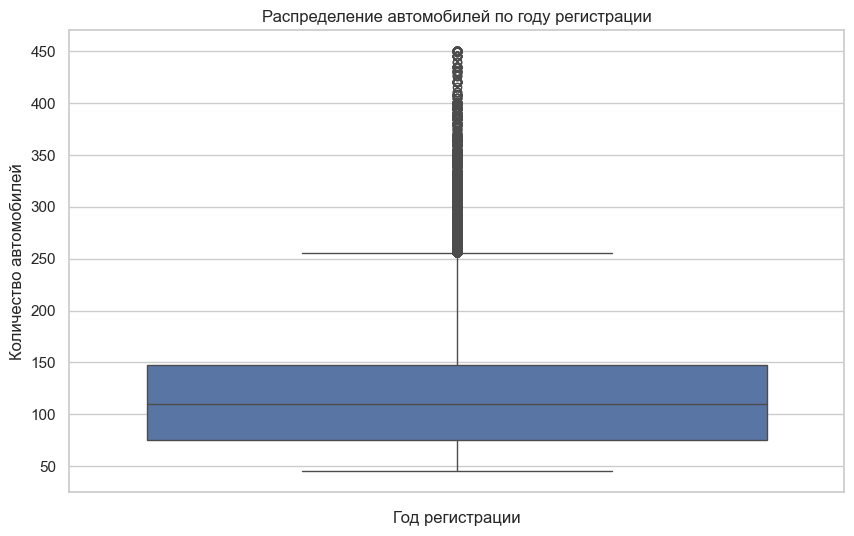

In [41]:
replace_outliers(data, 'power')
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data['power'])
plt.title('Распределение автомобилей по году регистрации')
plt.xlabel('Год регистрации') 
plt.ylabel('Количество автомобилей') 
plt.xticks(rotation=45)
plt.show() 

In [42]:
dataframe_summary(data, 'data')

Общая информация по таблице: data
<class 'pandas.core.frame.DataFrame'>
Index: 319205 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319205 non-null  int64 
 1   vehicle_type       319205 non-null  object
 2   registration_year  319205 non-null  int64 
 3   gearbox            319205 non-null  object
 4   power              319205 non-null  int64 
 5   model              319205 non-null  object
 6   kilometer          319205 non-null  int64 
 7   fuel_type          319205 non-null  object
 8   brand              319205 non-null  object
 9   repaired           319205 non-null  object
dtypes: int64(4), object(6)
memory usage: 26.8+ MB

 Статистическое описание:


,count,mean,std,min,25%,50%,75%,max
price,"319,205.00","4,620.53","4,525.41",1.00,"1,200.00","2,950.00","6,600.00","20,000.00"
registration_year,"319,205.00","2,003.64",6.24,"1,985.00","1,999.00","2,003.00","2,008.00","2,019.00"
power,"319,205.00",118.96,51.93,45.00,75.00,110.00,147.00,450.00
kilometer,"319,205.00","129,039.33","36,481.35","5,000.00","125,000.00","150,000.00","150,000.00","150,000.00"



Случайные примеры:


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
163716,1790,sedan,1990,manual,179,other,150000,petrol,mercedes_benz,no
177570,500,small,1997,manual,50,polo,150000,petrol,volkswagen,yes
117754,4899,small,2007,manual,65,other,70000,petrol,fiat,no
59104,10500,small,2013,manual,105,500,10000,petrol,fiat,no
62213,700,small,2002,manual,60,micra,150000,petrol,nissan,no



Количество строк и столбцов: (319205, 10)

Количество явных дубликатов: 56647



In [43]:
data.fuel_type	.unique()

array(['petrol', 'gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

Для оптимизации рабочих процессов компиьютера предлагаю уменьшить размерность данных где это возможно:
1) Можно перевести столбцы repaired и gearbox из разряда категориального в факторный, выразив как 1 и 0. 
2) Затем можно провести downсast всех числовых столбцов.

In [44]:
# Переименование столбца 'repaired' в 'is_repaired'
data.rename(columns={'repaired': 'is_repaired'}, inplace=True)

# Замена значений 'no' на 0 и 'yes' на 1 в столбце 'is_repaired'
data['is_repaired'] = data['is_repaired'].map({'no': 0, 'yes': 1})

In [45]:
# Переименование столбца 'gearbox' в 'is_automatic'
data.rename(columns={'gearbox': 'is_automatic'}, inplace=True)

# Замена значений 'manual' на 0 и 'auto' на 1 в столбце 'is_automatic'
data['is_automatic'] = data['is_automatic'].map({'manual': 0, 'auto': 1})

In [46]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Применяем downcast для каждого числового столбца
for col in numeric_cols:
    if data[col].dtype == 'int64':
        data[col] = pd.to_numeric(data[col], downcast='integer')  # Downcast целочисленных значений
    elif data[col].dtype == 'float64':
        data[col] = pd.to_numeric(data[col], downcast='float')

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 319205 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              319205 non-null  int16 
 1   vehicle_type       319205 non-null  object
 2   registration_year  319205 non-null  int16 
 3   is_automatic       319205 non-null  int8  
 4   power              319205 non-null  int16 
 5   model              319205 non-null  object
 6   kilometer          319205 non-null  int32 
 7   fuel_type          319205 non-null  object
 8   brand              319205 non-null  object
 9   is_repaired        319205 non-null  int8  
dtypes: int16(3), int32(1), int8(2), object(4)
memory usage: 15.8+ MB


Удалось снизить потребление памяти на 10 MB

## Обучение моделей

Разобъем данные на тренировочную и тестовую выборки:

In [49]:
X = data.drop('price', axis=1)  # Входные признаки (все кроме 'price')
y = data['price']  # Целевая переменная

# Разбиение на тренировочную и тестовую выборки с соотношением 80% к 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Вывод размеров полученных выборок для проверки
print(f"Тренировочная выборка: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Тестовая выборка: X_test: {X_test.shape}, y_test: {y_test.shape}")

Тренировочная выборка: X_train: (255364, 9), y_train: (255364,)
Тестовая выборка: X_test: (63841, 9), y_test: (63841,)


Зададим названия переменных

In [50]:
numeric_features = ['registration_year', 'is_automatic', 'power', 'is_repaired']
categorical_features = list(data.select_dtypes(include=['object']).columns)
# Определение колонок для каждого типа кодирования
ohe_features = ['vehicle_type', 'fuel_type']
ordinal_features = ['brand', 'model']

Настроим пайплайн последовательной трасформации данных

In [51]:
# Создание трансформера для числовых переменных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Определение колонок для каждого типа кодирования
ohe_features = ['vehicle_type', 'fuel_type']
ordinal_features = ['brand', 'model']

# Создание трансформеров
ohe_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Создание препроцессора, который применяет ohe и oe
preprocessor1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ohe', ohe_transformer, ohe_features),
        ('ordinal', ordinal_transformer, ordinal_features)
    ])

# Создание препроцессора, который применяет ohe
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', ohe_transformer, categorical_features)])

#### Model 1 RandomizedSearchCV + lgb.LGBMRegressor

In [52]:
# Параметры
param_dist = {
    'model__n_estimators': sp_randint(50, 150),
    'model__learning_rate': uniform(0.1, 0.2),
    'model__num_leaves': sp_randint(20, 150),
    'model__max_depth': sp_randint(-1, 10),
}

In [53]:
%%time

start_time = time.time()  


pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('model', lgb.LGBMRegressor(random_state=123))
])




random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=123,
    n_jobs=-2
)
random_search.fit(X_train, y_train)  

end_time = time.time()  

total_time = end_time - start_time
print("Общее время выполнения: {:.2f} секунд".format(total_time))
print("Лучшее значение RMSE:",np.sqrt(-random_search.best_score_))
print("Лучшие параметры:", random_search.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 831
[LightGBM] [Info] Number of data points in the train set: 255364, number of used features: 289
[LightGBM] [Info] Start training from score 4624.261662
Общее время выполнения: 87.00 секунд
Лучшее значение RMSE: 1705.740412055495
Лучшие параметры: {'model__learning_rate': 0.26526816010136667, 'model__max_depth': 0, 'model__n_estimators': 101, 'model__num_leaves': 137}
CPU times: total: 16.4 s
Wall time: 1min 26s


In [54]:
model1_time = total_time
model1_params = random_search.best_params_
model1_rmse = np.sqrt(-random_search.best_score_)

In [55]:
model1_params

{'model__learning_rate': 0.26526816010136667,
 'model__max_depth': 0,
 'model__n_estimators': 101,
 'model__num_leaves': 137}

#### Model 2 RandomizedSearchCV + CatboostReg.

In [56]:
%%time

start_time = time.time()  

pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', CatBoostRegressor(silent=True))
])


param_distributions = {
    'regressor__depth': np.arange(4, 10),
    'regressor__learning_rate': np.logspace(-3, -1, 10),
    'regressor__iterations': [100, 200, 300, 400, 500],
    'regressor__l2_leaf_reg': np.logspace(-2, 0, 10)
}


random_search_cat = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=5, 
    cv=3,  
    scoring='neg_mean_squared_error',  
    verbose=1,
    random_state=123,
    n_jobs=-2  
)


random_search_cat.fit(X_train, y_train)

end_time = time.time() 


total_time = end_time - start_time


print("Общее время выполнения: {:.2f} секунд".format(total_time))
print("Лучшее значение RMSE:", np.sqrt(-random_search_cat.best_score_))
print("Лучшие параметры:", random_search_cat.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


Общее время выполнения: 45.40 секунд
Лучшее значение RMSE: 1946.1360118938992
Лучшие параметры: {'regressor__learning_rate': 0.021544346900318832, 'regressor__l2_leaf_reg': 0.0774263682681127, 'regressor__iterations': 400, 'regressor__depth': 6}
CPU times: total: 40.4 s
Wall time: 45.4 s


In [57]:
model2_time = total_time
model2_params = random_search_cat.best_params_
model2_rmse = np.sqrt(-random_search_cat.best_score_)

#### Model 3 RandomizedSearchCV + RandomForestRegressor.

In [59]:
%%time


# Создание пайплайна, включающего предобработчик и RandomForestRegressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # preprocessor уже определен ранее
    ('regressor', RandomForestRegressor(random_state=42))
])

# Определение диапазона гиперпараметров для RandomizedSearchCV
param_distributions = {
    'regressor__n_estimators': randint(10, 30),  # Количество деревьев в лесу
    'regressor__max_depth': randint(2, 10),  # Максимальная глубина дерева
    'regressor__min_samples_split': randint(2, 11),  # Минимальное количество образцов, необходимое для разделения внутреннего узла
    'regressor__min_samples_leaf': randint(1, 11)  # Минимальное количество образцов, необходимое в листовом узле
}
start_time = time.time()  # Начало замера времени
# Создание и запуск RandomizedSearchCV
forest_reg = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=2,  # Количество итераций поиска (можете увеличить для лучшего подбора)
    cv=3,  # Количество фолдов кросс-валидации
    scoring='neg_mean_squared_error',  # Метрика для оценки
    verbose=1,
    random_state=42,
    n_jobs=-2  # Использование всех доступных ядер
)

# Обучение модели
forest_reg.fit(X_train, y_train)

end_time = time.time()  # Конец замера времени

# Вычисление и сохранение общего времени выполнения
total_time = end_time - start_time

# Вывод лучших параметров и соответствующего им значения метрики
print("Лучшие параметры:", forest_reg.best_params_)
print("Лучшее значение метрики (RMSE):", np.sqrt((-forest_reg.best_score_)))
print("Лучшие параметры:", forest_reg.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


Лучшие параметры: {'regressor__max_depth': 8, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 9, 'regressor__n_estimators': 16}
Лучшее значение метрики (RMSE): 2067.938455325221
Лучшие параметры: {'regressor__max_depth': 8, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 9, 'regressor__n_estimators': 16}
CPU times: total: 22 s
Wall time: 43.6 s


In [60]:
model3_time = total_time
model3_params = forest_reg.best_params_
model3_rmse = np.sqrt(-forest_reg.best_score_)

## Анализ моделей

Соберем всю нашу инфорамацию о моделях в один датафрейм:

In [61]:
# Сборка результатов в DataFrame
results_df = pd.DataFrame({
    'Model': ['RandomizedSearchCV + LGBM', 'RandomizedSearchCV + CatBoost', 'RandomizedSearchCV + RandomForest'],
    'Execution Time (sec)': [model1_time, model2_time, model3_time],
    'Best Parameters': [model1_params, model2_params, model3_params],
    'RMSE': [model1_rmse, model2_rmse, model3_rmse]
})

# Вывод таблицы на экран
display(results_df)

,Model,Execution Time (sec),Best Parameters,RMSE
0,RandomizedSearchCV + LGBM,87.00,"{'model__learning_rate': 0.26526816010136667, ...","1,705.74"
1,RandomizedSearchCV + CatBoost,45.40,{'regressor__learning_rate': 0.021544346900318...,"1,946.14"
2,RandomizedSearchCV + RandomForest,43.65,"{'regressor__max_depth': 8, 'regressor__min_sa...","2,067.94"


Лучше всего себя показала модель RandomizedSearchCV + LGBM, проверим ее на тестовых данных.

In [62]:
%%time

# Предсказание значений для тестового набора данных
y_pred = random_search.predict(X_test)

# Расчет Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Расчет Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)


print("RMSE финальной модели на тестовой выборке:", rmse)

RMSE финальной модели на тестовой выборке: 1681.8746847088357
CPU times: total: 609 ms
Wall time: 213 ms


#### **Итоги работы с моделями машинного обучения**

**Обзор моделей**

Были обучены и оптимизированы три различные модели машинного обучения для задачи регрессии с использованием RandomizedSearchCV:

* `LightGBM Regressor`

  * Время выполнения: 87 секунд
  * Лучшие параметры: {model__learning_rate: 0.265, model__max_depth: 0, model__n_estimators: 101, model__num_leaves: 137}
  * RMSE: 1705.74
* `CatBoost Regressor`

  * Время выполнения: 45.4 секунд
  * Лучшие параметры: {regressor__learning_rate: 0.0215}
  * RMSE: 1946.14
* `Random Forest Regressor`

  * Время выполнения: 43.65 секунд
  * Лучшие параметры: {regressor__max_depth: 8, regressor__min_samples_leaf: 4, regressor__min_samples_split: 9, regressor__n_estimators: 16}
  * RMSE: 2067.94

**Финальная модель**
Из трех рассмотренных моделей, LightGBM Regressor показал лучший результат по метрике RMSE (1705.74) на кросс-валидации. Это делает её предпочтительным выбором для данной задачи регрессии среди рассмотренных моделей.

**Время выполнения и эффективность** 

Несмотря на то, что LightGBM показал наилучшую производительность с точки зрения RMSE, модель также требовала наибольшее время для выполнения среди всех трех.
CatBoost и Random Forest показали себя как более быстрые модели, но с более высоким RMSE, что указывает на потенциальное ухудшение качества предсказаний.
Выводы
LightGBM Regressor стал лучшим выбором для решения поставленной задачи благодаря оптимальному сочетанию точности предсказаний и времени выполнения, несмотря на то, что он занял больше времени по сравнению с другими моделями.
Однако, при выборе модели для внедрения в продакшн следует также учитывать другие факторы, такие как интерпретируемость модели, время инференса и ресурсы на обучение.

**Рекомендации**

Для дальнейшего улучшения модели и минимизации RMSE рекомендуется:

* Дополнительно исследовать пространство гиперпараметров.
* Провести анализ важности признаков и исключить менее важные, что может улучшить качество модели и уменьшить время обучения.
* Рассмотреть возможность использования ансамблевых методов, объединяющих предсказания нескольких моделей.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей